In [2]:
from Bio import Phylo 
from io import StringIO

In [3]:
tree_nwk = "((A,B,C),((D,E,F),G,H),I)"
tree = Phylo.read(StringIO(tree_nwk), format="newick")

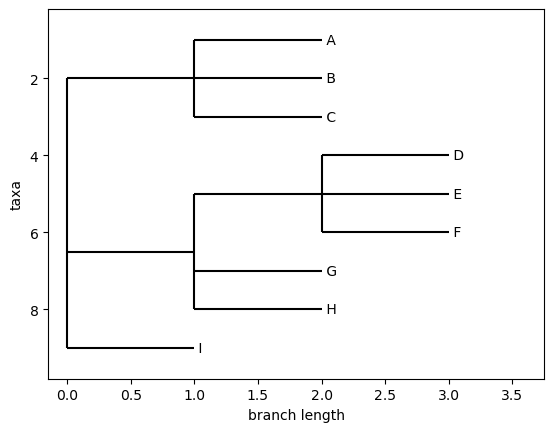

In [4]:
Phylo.draw(tree)

In [5]:
root = tree.root

In [6]:
next(iter(root.find_elements(terminal=True)))

Clade(name='A')

In [7]:
id = 0
def get_new_name():
    global id
    id += 1
    return f"_{id}"

def reset_name():
    global id
    id = 0

In [8]:
reset_name()
for node in tree.find_clades(terminal=False):
    node.name = get_new_name()

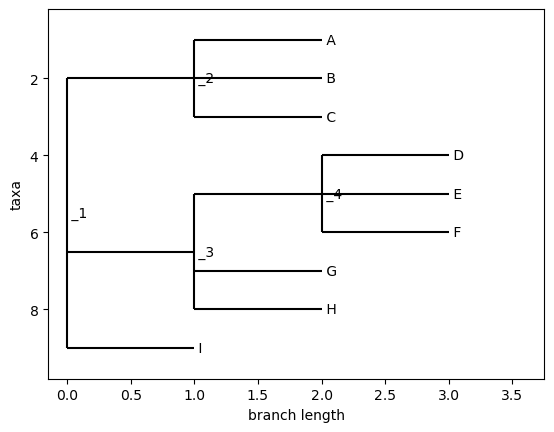

In [9]:
Phylo.draw(tree)

In [10]:
all_leaf_names = map(lambda x : x.name, tree.find_elements(terminal=True))
print(list(all_leaf_names))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']


In [11]:
root.clades[0].clades

[Clade(name='A'), Clade(name='B'), Clade(name='C')]

In [12]:
all_clades = tree.find_clades() 
for clade in all_clades:
    if(len(clade.clades) > 2): 
        print(clade)

_1
_2
_3
_4


In [13]:
polytomies = list(filter(
    lambda x : 
        len(x.clades) > 2 if x != tree.root
        else len(x.clades) > 3
    ,
    tree.find_clades(),
))

In [14]:
poly_label_map = { polytomy.name: {} for polytomy in polytomies }

In [15]:
poly_label_map

{'_2': {}, '_3': {}, '_4': {}}

In [16]:
for poly in polytomies:
    path = [None, tree.root] + tree.get_path(poly)
    # print(f"{poly=} {path=}")
    if not path:
        raise ValueError(f"Could not find parent of {poly=}")
    else:
        parent = path[-2]
    print(f"{poly=} {parent=}") 

    for child in poly.clades: 
        leaves = list(child.find_elements(terminal=True))
        # print(f"{child=}, {leaves=}")
        for leaf in leaves: 
            poly_label_map[poly.name][leaf.name] = child.name
    if parent is not None:
        leaves = [ # the rest of the leaves
            l for l in tree.find_elements(terminal=True)
            if l not in poly.find_elements()
        ]
        for leaf in leaves: 
            poly_label_map[poly.name][leaf.name] = parent.name
    print(len(poly_label_map[poly.name]))




poly=Clade(name='_2') parent=Clade(name='_1')
9
poly=Clade(name='_3') parent=Clade(name='_1')
9
poly=Clade(name='_4') parent=Clade(name='_3')
9


In [17]:
from collections import Counter
polytomy_quartets = { polytomy.name: Counter() for polytomy in polytomies }

In [18]:
def update_quartet(
    q: tuple[str, str, str, str],
    w: int,
    polytomy_quartets: dict[str, Counter],
):
    # q has format (a, b, c, d), represents ab|cd
    # please check that a,b,c,d are in the leafset 
    # w is an integer weight
    for poly in polytomies: 
        pn = poly.name 
        relabelled_tuple = tuple(map(
            lambda u: poly_label_map[pn][u],
            q
        ))
        if len(set(relabelled_tuple)) == 4: # four different children
            print(f"Updating {pn=}: {relabelled_tuple=}")
            polytomy_quartets[pn][relabelled_tuple] += w
            return # a quartet can be in at most one polytomy

In [19]:
update_quartet(
    ('A', 'B', 'C', 'D'),
    w = 1,
    polytomy_quartets=polytomy_quartets,
)

Updating pn='_2': relabelled_tuple=('A', 'B', 'C', '_1')


In [24]:
import os 
from pathlib import Path

output_path = "/projects/illinois/eng/cs/warnow/zxliu2/QuartetPolytomy/tmp"
run_name = "test_qp"

FOLDER = Path(output_path) / run_name

In [34]:
for polytomy in polytomies:
    print(polytomy.name)
    polytomy_folder = FOLDER / polytomy.name
    os.makedirs(polytomy_folder, exist_ok=True)
    # what happens if the leafset is not fully determined? for neighbours a,b,c,d add 
    # ab|cd, ac|bd, and ad|bc so that no bias
    # and make sure each leaf is in at least one quartet.
    with open(polytomy_folder / 'quartets.nwk', 'w') as qf:
        poly_neighbours = list(set(poly_label_map[polytomy.name].values())) # 
        for i in range(len(poly_neighbours) - 3):
            a, b, c, d = poly_neighbours[i:i+4]
            qf.write(f'(({a},{b}),({c},{d}));\n')
            qf.write(f'(({a},{c}),({b},{d}));\n')
            qf.write(f'(({a},{d}),({c},{d}));\n')

        for (a, b, c, d), w in polytomy_quartets[polytomy.name].items():
            qf.write(f'(({a},{b}),({c},{d}));\n' * w)
    

_2
_3
_4
